# Fitting a Model to Data
Latino Initiative Program Python Hour, 2019 July 22

By: Griffin Hosseinzadeh (griffin.hosseinzadeh@cfa.harvard.edu)

A common problem in astrophysics (any science really) is that you have some data and you want to use it to constrain a theoretical model. In other words, what parameters can you plug into the model to make it match your observations?
[Here's an example](https://ui.adsabs.harvard.edu/abs/2017ApJ...845L..11H/graphics) from one of my papers.

This notebook explores several techniques for doing this fitting in Python.

In [1]:
import numpy as np
import scipy.optimize
import emcee
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Define Your Model
Write a function that takes some x-values and model parameters and returns y-values according to your model. Let's start with a linear model, $y = mx + b$.

In [2]:
def model(x, slope, intercept):
    """A linear model."""
    y = slope * x + intercept
    return y

## 2. Generate Some Fake Data
Normally we would have real astronomical data to use, but since I want to show you how this works, we are going to make up some data. Randomly choose some parameters (slope and intercept) for your model. Then evaluate the model over the range $x=0$ to $x=10$. Plot your fake data using `plt.plot`.

Text(0.5, 1.0, 'Fake Data')

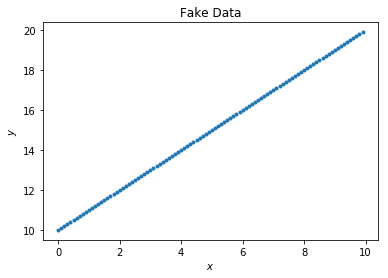

In [3]:
p_true = [1., 10.]
x = np.arange(0., 10., 0.1)
y = model(x, p_true[0], p_true[1])
plt.plot(x, y, '.')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fake Data')

If these were real data, they would not be so perfect. So let's add in some noise using the `np.random` module. Plot the noisy data using `plt.errorbar`.

Text(0.5, 1.0, 'Fake Data with Noise')

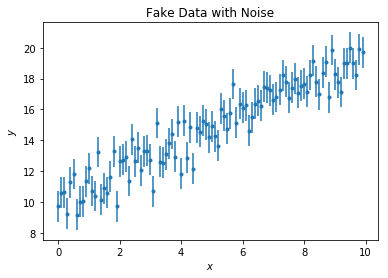

In [4]:
unc = 1.
y_noisy = y + unc * np.random.standard_normal(len(y))
plt.errorbar(x, y_noisy, unc, fmt='.')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fake Data with Noise')

From here on, we are going to use `x` and `y_noisy` as our data. Each time we try to fit the data with our model, we will compare our results to the `p_true` that we used to generate the data.

## 3. Fit a Polynomial Model with `np.polyfit`
Since our model is a polynomial, the easiest thing we can use is `np.polyfit`. Look at the documentation for that function and use it to fit a 1st degree polynomial (a straight line) to our noisy data. Print the parameters you get, and plot the results.

[ 0.95368462 10.07541937] [1.0, 10.0]


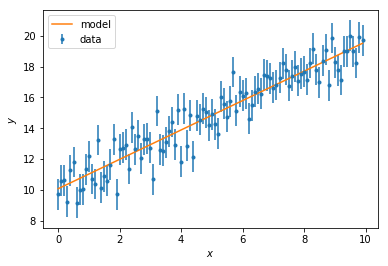

In [5]:
p_fit = np.polyfit(x, y_noisy, 1)
y_fit = model(x, p_fit[0], p_fit[1])
plt.errorbar(x, y_noisy, unc, fmt='.', label='data')
plt.plot(x, y_fit, label='model')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
print(p_fit, p_true)

## 4. Fit a Linear Model with `scipy.optimize.curve_fit`.
The next thing we can try is `scipy.optimize.curve_fit`. This function can fit _any_ model, as long as you can write it down as a function. Luckily we have already done this when we generated the data. Give `curve_fit` the model and the noisy data and see what parameters it comes up with. Compare these to `np.polyfit` and the true parameters. Plot the results.

[ 0.95368462 10.07541937] [1.0, 10.0]


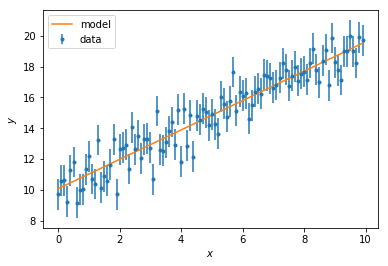

In [6]:
p_curve_fit, cov_curve_fit = scipy.optimize.curve_fit(model, x, y_noisy)
y_curve_fit = model(x, p_curve_fit[0], p_curve_fit[1])
plt.errorbar(x, y_noisy, unc, fmt='.', label='data')
plt.plot(x, y_curve_fit, label='model')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
print(p_curve_fit, p_true)

## 5. Redo All of the Above with a Non-Polynomial Model
This all works great, but it's pretty easy to fit a line. (You could even do it without a computer if you were patient enough!) Let's see what happens if you use a model that is not a polynomial. You could try a sinusoid, an exponential, a power law, or any other function you can think of. Stick with 2 parameters for now. Once you do that, repeat Sections 2-4.

Text(0.5, 1.0, 'Fake Data with Noise')

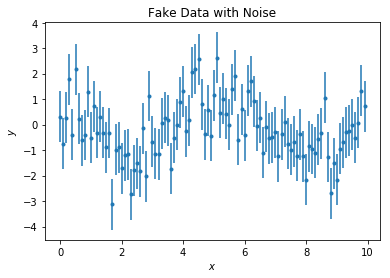

In [7]:
def model(x, amplitude, phase):
    """A sinusoidal model."""
    y = amplitude * np.sin(x - phase)
    return y

p_true = [1., 10.]
unc = 1.

x = np.arange(0., 10., 0.1)
y = model(x, p_true[0], p_true[1])
y_noisy = y + unc * np.random.standard_normal(len(y))

plt.errorbar(x, y_noisy, unc, fmt='.')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fake Data with Noise')

## Advanced: Use Markov-Chain Monte Carlo Regression
We won't have time to do this today, but below is an example of using a more advanced Bayesian statistical technique to find the best fit parameters *with uncertainties* for any model function. For more details, try the tutorial at https://emcee.readthedocs.io/.

[0.83051481 3.79921732]
[1.0969168  3.71395679]
[1.26992466 3.52664707]
[1.11311703 3.79543758]
[1.04668374 3.77295725]
[1.03248128 3.99089712]
[0.99329696 3.51816001]
[0.87458112 3.8426131 ]
[1.1564707  3.50576353]
[1.02540835 3.7374029 ]


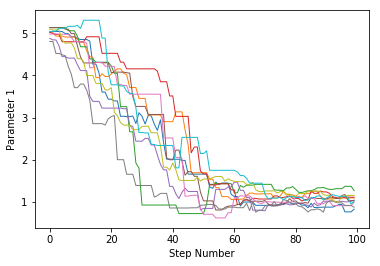

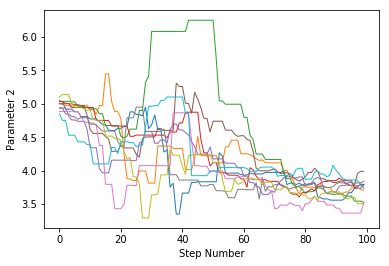

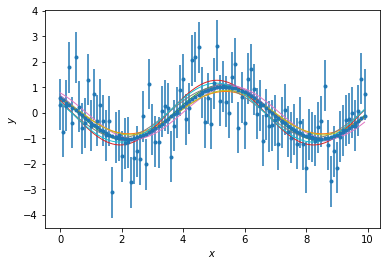

In [8]:
# Define the probability of a model being correct.
# This is related to the residuals (how far the points are from the model).
def log_posterior(p, x, y, unc):
    """Posterior probability distribution, assuming uniform priors."""
    if p[0] > 0. and 0. < p[1] < 2. * np.pi:
        y_fit = model(x, p[0], p[1])
        resid = y - y_fit
        log_prob = np.sum(-resid**2. / (2. * unc**2.) - np.log(unc))
    else:
        log_prob = -np.inf
    return log_prob

# Make some initial guesses about what the parameters are.
# In this case, I chose random numbers around 5 for both.
initial_guesses = 0.1 * np.random.standard_normal((10, 2)) + 5.

# Set up the "sampler" object. This contains 10 "walkers" that are going to explore the parameter space.
# They each "walk" for 100 steps and eventually end up at values near the true parameters.
sampler = emcee.EnsembleSampler(10, 2, log_posterior, args=(x, y, unc))
sampler.run_mcmc(initial_guesses, 100)

# Plot the path each walker takes over its 100 steps.
# You can see that they converge on values near the true value.
plt.figure()
plt.plot(sampler.chain[:, :, 0].T, lw=1)
plt.xlabel('Step Number')
plt.ylabel('Parameter 1')

plt.figure()
plt.plot(sampler.chain[:, :, 1].T, lw=1)
plt.xlabel('Step Number')
plt.ylabel('Parameter 2')

# For each pair of parameters, you can plot the model.
# Notice how they all seem to fit equally well, given the noise.
# Later you could take the mean/median and standard deviation of these parameters.
p_emcee = sampler.chain[:, -1]
plt.figure()
plt.errorbar(x, y_noisy, unc, fmt='.')
plt.xlabel('$x$')
plt.ylabel('$y$')
for p in p_emcee:
    print(p)
    y_emcee = model(x, p[0], p[1])
    plt.plot(x, y_emcee, lw=1)